<a href="https://colab.research.google.com/github/ChenghenChen/Slum/blob/main/030624.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install segment-geospatial leafmap pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.5/262.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


In [5]:
# 分割图像函数
def split_image(image_path, out_dir, grid_size=10):
    img = Image.open(image_path)
    img_width, img_height = img.size
    tile_width, tile_height = img_width // grid_size, img_height // grid_size

    # 创建输出目录
    os.makedirs(out_dir, exist_ok=True)

    for i in range(grid_size):
        for j in range(grid_size):
            box = (j * tile_width, i * tile_height, (j + 1) * tile_width, (i + 1) * tile_height)
            out_path = os.path.join(out_dir, f'tile_{i}_{j}.png')
            img.crop(box).save(out_path, 'PNG')


In [6]:
# 重组并显示图像函数
def reassemble_and_show(split_dir, grid_size=10, line_color=(255, 0, 0), line_width=2):
    first_image_path = os.path.join(split_dir, 'tile_0_0.png')
    first_img = Image.open(first_image_path)
    tile_width, tile_height = first_img.size

    full_width, full_height = tile_width * grid_size, tile_height * grid_size
    full_image = Image.new('RGB', (full_width, full_height))

    for i in range(grid_size):
        for j in range(grid_size):
            img_path = os.path.join(split_dir, f'tile_{i}_{j}.png')
            img = Image.open(img_path)
            full_image.paste(img, (j * tile_width, i * tile_height))

    draw = ImageDraw.Draw(full_image)
    for i in range(1, grid_size):
        draw.line([(0, i * tile_height), (full_width, i * tile_height)], fill=line_color, width=line_width)
        draw.line([(i * tile_width, 0), (i * tile_width, full_height)], fill=line_color, width=line_width)
    del draw

    plt.figure(figsize=(10, 10))
    plt.imshow(full_image)
    plt.axis('off')
    plt.show()


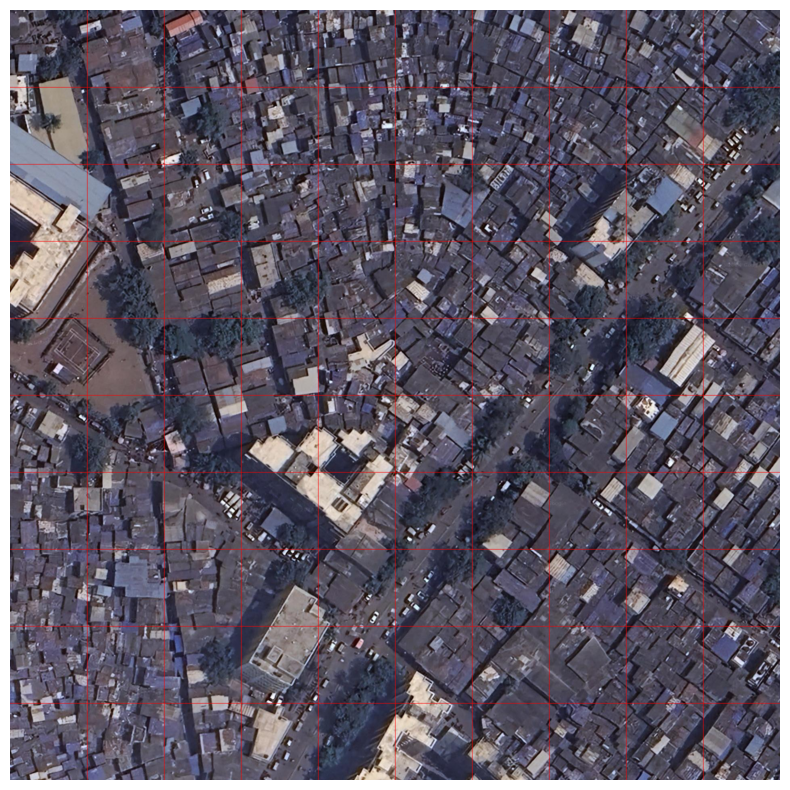

In [7]:
# 分割原始图像并重组展示
original_image_path = '/content/drive/MyDrive/Colab/Artboard 1 copy 3.png'  # 原始图像路径
split_images_dir = '/content/drive/MyDrive/Colab/SplitImages'  # 分割图像保存目录
split_image(original_image_path, split_images_dir)  # 分割图像
reassemble_and_show(split_images_dir)  # 重组并显示图像


In [8]:
from samgeo import SamGeo

# 初始化 SAMGEO 模型
sam = SamGeo(model_type="vit_h", checkpoint="sam_vit_h_4b8939.pth")

# 检查已经处理过的图像
processed_files = set()
processed_file_path = '/content/drive/My Drive/SplitImages/processed.txt'  # 处理过的图像列表
if os.path.exists(processed_file_path):
    with open(processed_file_path, 'r') as f:
        processed_files = set(f.read().splitlines())

# 处理每个小图像
for i in range(10):
    for j in range(10):
        tile_path = f'{split_images_dir}/tile_{i}_{j}.png'
        if tile_path in processed_files:
            continue  # 跳过已处理的图像

        # 分割并保存
        segmented_path = f'{split_images_dir}/segmented_tile_{i}_{j}.png'
        sam.generate(tile_path, segmented_path, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255)

        # 记录处理过的图像
        with open(processed_file_path, 'a') as f:
            f.write(f"{tile_path}\n")

        # 可选：展示第一张图的分割结果
        if i == 0 and j == 0:
            from PIL import Image
            import matplotlib.pyplot as plt

            # 显示第一张分割后的图像
            segmented_img = Image.open(segmented_path)
            plt.figure(figsize=(8, 8))
            plt.imshow(segmented_img)
            plt.title("Segmented Tile 0_0")
            plt.show()


Model checkpoint for vit_h not found.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:29<00:00, 87.1MB/s]


In [24]:
from samgeo import SamGeo

# 初始化 SAMGEO 模型
sam = SamGeo(model_type="vit_h", checkpoint="sam_vit_h_4b8939.pth")

# 检查已经处理过的图像
processed_files = set()
processed_file_path = '/content/drive/My Drive/SplitImages/processed.txt'
if os.path.exists(processed_file_path):
    with open(processed_file_path, 'r') as f:
        processed_files = set(f.read().splitlines())

# 处理每个小图像
for i in range(10):
    for j in range(10):
        tile_path = f'{split_images_dir}/tile_{i}_{j}.png'
        if tile_path in processed_files:
            continue  # 跳过已处理的图像

        # 分割并保存
        segmented_path = f'{split_images_dir}/segmented_tile_{i}_{j}.png'
        sam.generate(tile_path, segmented_path, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255)

        # 记录处理过的图像
        with open(processed_file_path, 'a') as f:
            f.write(f"{tile_path}\n")

        # 可选：展示第一张图的分割结果
        if i == 0 and j == 0:  # 仅展示第一个图像作为示例
            from PIL import Image
            import matplotlib.pyplot as plt
            segmented_img = Image.open(segmented_path)
            plt.figure(figsize=(8, 8))
            plt.imshow(segmented_img)
            plt.title("Segmented Tile 0_0")
            plt.show()


提高SAMGEO的靈敏度

In [ ]:
# 导入必要的库
import os
from PIL import Image
import matplotlib.pyplot as plt
from samgeo import SamGeo  # 假设您已经安装了SAMGEO或类似的库

# 确保 Google Drive 已正确挂载
from google.colab import drive
drive.mount('/content/drive')

# 设置原始图像分割和处理后图像存储的目录
split_images_dir = '/content/drive/MyDrive/Colab/SplitImages'  # 包含原始分割图像的目录
new_folder_path = '/content/drive/MyDrive/Colab/SplitImages22'  # 处理后的图像要保存的新目录
os.makedirs(new_folder_path, exist_ok=True)  # 确保新目录存在

# 初始化 SAMGEO 模型
sam = SamGeo(model_type="vit_h", checkpoint="sam_vit_h_4b8939.pth")

# 检查已经处理过的图像
processed_files = set()
processed_file_path = os.path.join(new_folder_path, 'processed.txt')  # 处理过的图像列表存放于新目录
if os.path.exists(processed_file_path):
    with open(processed_file_path, 'r') as f:
        processed_files = set(f.read().splitlines())

# 处理每个小图像
for i in range(10):
    for j in range(10):
        tile_path = f'{split_images_dir}/tile_{i}_{j}.png'
        if tile_path in processed_files:
            continue  # 跳过已处理的图像

        # 分割并保存，这里修改为保存在新目录
        segmented_path = os.path.join(new_folder_path, f'segment_tile_{i}_{j}.png')
        sam.generate(tile_path, segmented_path, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255)

        # 记录处理过的图像
        with open(processed_file_path, 'a') as f:
            f.write(f"{tile_path}\n")

        # 可选：展示第一张图的分割结果
        if i == 0 and j == 0:  # 仅展示第一个图像作为示例
            segmented_img = Image.open(segmented_path)
            plt.figure(figsize=(8, 8))
            plt.imshow(segmented_img, cmap='gray')
            plt.title("Segmented Tile 0_0")
            plt.axis('off')
            plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/1 [00:00<?, ?it/s]WARNING:rasterio._env:CPLE_AppDefined in libpng: iCCP: known incorrect sRGB profile


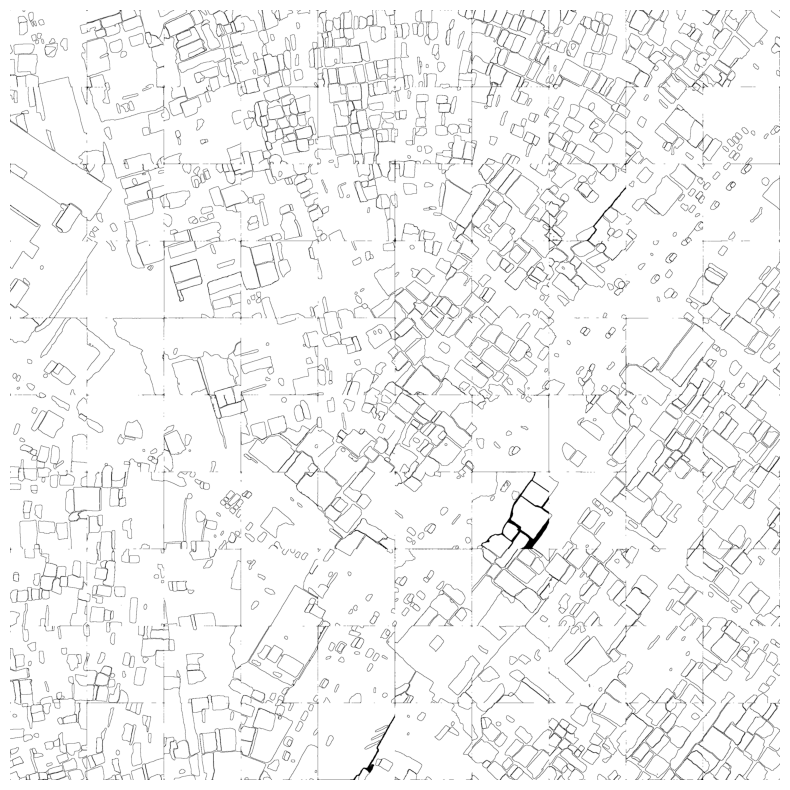

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def remove_borders_and_reassemble(split_dir, grid_size=10, border_size=2):
    # 假设所有小图像的大小相同，获取第一张小图的大小来计算全图尺寸
    sample_img_path = os.path.join(split_dir, 'segmented_tile_0_0.png')
    sample_img = Image.open(sample_img_path)
    tile_width, tile_height = sample_img.size

    # 减去边界后的每张小图的大小
    cropped_tile_width = tile_width - 2 * border_size
    cropped_tile_height = tile_height - 2 * border_size

    # 计算全图的尺寸
    full_width = cropped_tile_width * grid_size
    full_height = cropped_tile_height * grid_size

    # 创建一个新图像，尺寸为全图尺寸
    full_image = Image.new('RGB', (full_width, full_height))

    # 逐一读取分割后的图像，移除边界，并将其放置在正确的位置
    for i in range(grid_size):
        for j in range(grid_size):
            segment_path = os.path.join(split_dir, f'segmented_tile_{i}_{j}.png')
            if os.path.exists(segment_path):  # 确保图像文件存在
                img = Image.open(segment_path)
                # 裁剪图像以移除边界
                cropped_img = img.crop((border_size, border_size, tile_width - border_size, tile_height - border_size))
                # 计算在新图像中的位置
                left = j * cropped_tile_width
                top = i * cropped_tile_height
                full_image.paste(cropped_img, (left, top))

    return full_image

# 指定分割后的图像存储目录
split_images_dir = '/content/drive/MyDrive/Colab/SplitImages'  # 根据实际路径修改
# 调用函数，移除边界并重组图像
reassembled_image = remove_borders_and_reassemble(split_images_dir, grid_size=10, border_size=2)

# 显示重组后的图像
plt.figure(figsize=(10, 10))
plt.imshow(reassembled_image)
plt.axis('off')  # 不显示坐标轴
plt.show()


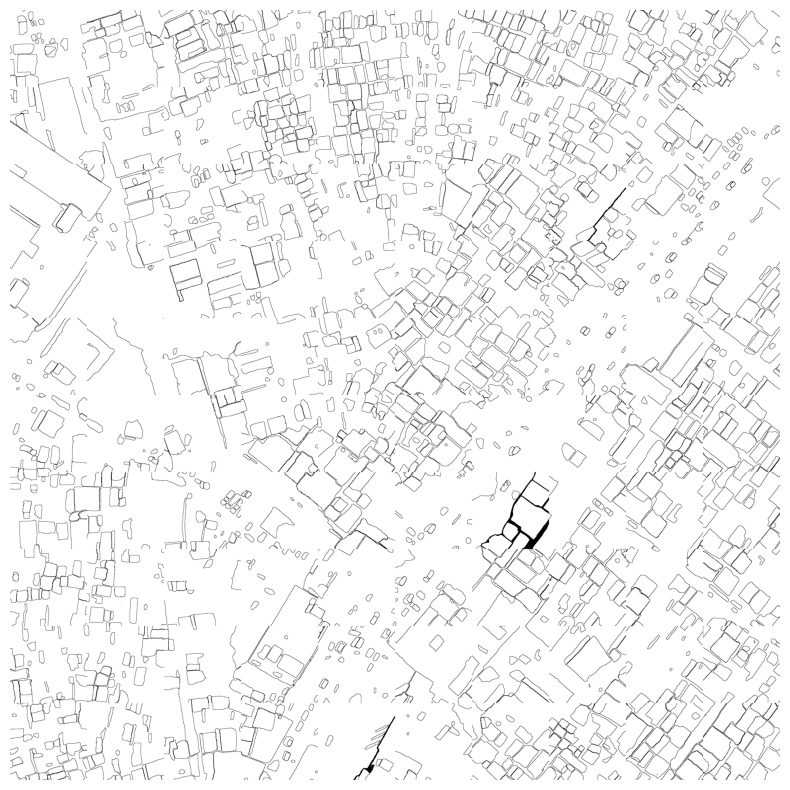

In [16]:
def remove_borders_and_reassemble(split_dir, grid_size=10, border_size=4):  # 尝试将border_size增加到4或根据需要调整
    # 假设所有小图像的大小相同，获取第一张小图的大小来计算全图尺寸
    sample_img_path = os.path.join(split_dir, 'segmented_tile_0_0.png')
    if not os.path.exists(sample_img_path):
        raise FileNotFoundError("Sample image not found. Please check the split directory path and naming convention.")
    sample_img = Image.open(sample_img_path)
    tile_width, tile_height = sample_img.size

    # 减去边界后的每张小图的大小
    cropped_tile_width = tile_width - 2 * border_size
    cropped_tile_height = tile_height - 2 * border_size

    # 计算全图的尺寸
    full_width = cropped_tile_width * grid_size
    full_height = cropped_tile_height * grid_size

    # 创建一个新图像，尺寸为全图尺寸
    full_image = Image.new('RGB', (full_width, full_height))

    # 逐一读取分割后的图像，移除边界，并将其放置在正确的位置
    for i in range(grid_size):
        for j in range(grid_size):
            segment_path = os.path.join(split_dir, f'segmented_tile_{i}_{j}.png')
            if os.path.exists(segment_path):  # 确保图像文件存在
                img = Image.open(segment_path)
                # 裁剪图像以移除边界
                cropped_img = img.crop((border_size, border_size, tile_width - border_size, tile_height - border_size))
                # 计算在新图像中的位置
                left = j * cropped_tile_width
                top = i * cropped_tile_height
                full_image.paste(cropped_img, (left, top))

    return full_image

# 使用更新的函数重组图像，并显示结果
split_images_dir = '/content/drive/MyDrive/Colab/SplitImages'  # 确保路径正确
reassembled_image = remove_borders_and_reassemble(split_images_dir, grid_size=10, border_size=4)  # 根据需要调整border_size

# 显示重组后的图像
plt.figure(figsize=(10, 10))
plt.imshow(reassembled_image)
plt.axis('off')  # 不显示坐标轴
plt.show()


保存图像到 Google Drive

In [17]:
# 定义保存路径
save_path = '/content/drive/MyDrive/Colab/ReassembledImage.png'

# 保存图像
reassembled_image.save(save_path)

print(f'图像已保存到：{save_path}')


图像已保存到：/content/drive/MyDrive/Colab/ReassembledImage.png


将图像中的线条转换成向量文件

In [18]:
!pip install opencv-python-headless


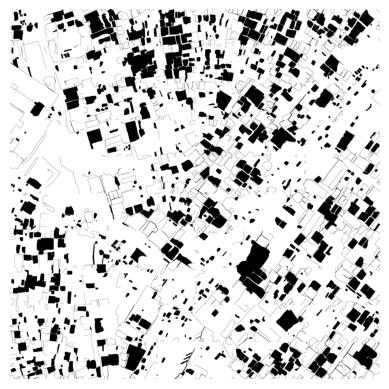

True

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取重组后的图像
image_path = '/content/drive/MyDrive/Colab/ReassembledImage.png'  # 更新为实际路径
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 二值化
_, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# 查找轮廓
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 创建一个全白的图像用于绘制轮廓和填充
filled_contours = np.ones_like(image) * 255

# 绘制并填充轮廓
cv2.drawContours(filled_contours, contours, -1, (0, 0, 0), thickness=cv2.FILLED)

# 显示填充后的图像
plt.imshow(filled_contours, cmap='gray')
plt.axis('off')
plt.show()

# 保存填充后的图像
filled_image_path = '/content/drive/MyDrive/Colab/FilledImage.png'
cv2.imwrite(filled_image_path, filled_contours)


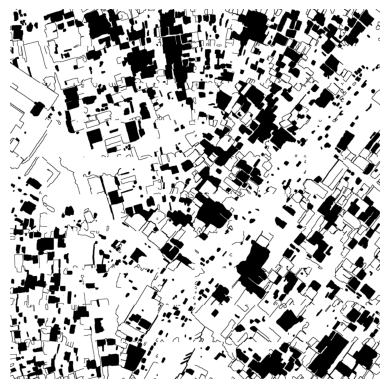

True

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取重组后的图像
image_path = '/content/drive/MyDrive/Colab/FilledImage.png'  # 更新为实际路径
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 调整二值化阈值
thresh_value = 50  # 降低阈值
_, binary = cv2.threshold(image, thresh_value, 255, cv2.THRESH_BINARY_INV)

# 使用图像膨胀
kernel = np.ones((3,3),np.uint8)  # 定义膨胀的核大小
dilated = cv2.dilate(binary, kernel, iterations = 1)  # 进行膨胀操作

# 查找轮廓
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 创建一个全白的图像用于绘制轮廓和填充
filled_contours = np.ones_like(image) * 255

# 绘制并填充轮廓
cv2.drawContours(filled_contours, contours, -1, (0, 0, 0), thickness=cv2.FILLED)

# 显示填充后的图像
plt.imshow(filled_contours, cmap='gray')
plt.axis('off')
plt.show()

# 保存填充后的图像
filled_image_path = '/content/drive/MyDrive/Colab/FilledImage_Adjusted.png'  # 保存路径
cv2.imwrite(filled_image_path, filled_contours)
